In [1]:
%cd /content/drive/My Drive/DeepLearning

/content/drive/My Drive/DeepLearning


In [2]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 6.7MB/s 


In [3]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-6f_86ynm
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-6f_86ynm
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=263404cc15a4299b71365ffaae4a385e6ce048f6153f55ec8ff80bb88245cc87
  Stored in directory: /tmp/pip-ephem-wheel-cache-grfbanh2/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [4]:
from PIL import Image
from mtcnn.mtcnn import MTCNN
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
from tensorflow.keras.utils import to_categorical
import os

Using TensorFlow backend.


In [0]:
def load_data(DATA_FILE):
  data = np.load(DATA_FILE)
  X_train, X_test,y_train, y_test ,num_class = data["arr_0"],data["arr_1"],data["arr_2"],data["arr_3"],data["arr_4"]
  num_class = np.asscalar(num_class)
  return X_train, X_test,y_train, y_test ,num_class

In [39]:
DATA_FILE = "data_face_train_imb.npz"
X_train, X_test,y_train, y_test ,num_class = load_data(DATA_FILE)
print(X_train.shape)
print(X_test.shape)
print(num_class)

(2352, 224, 224, 3)
(589, 224, 224, 3)
53


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  after removing the cwd from sys.path.


In [7]:
#X_val, y_val = X_train[8000:], y_train[8000:]
#X_train, y_train = X_train[:8000], y_train[:8000]
y_train = to_categorical(y_train, num_class)
#y_val = to_categorical(y_val, num_class)
y_test = to_categorical(y_test, num_class)

#X_val = X_val / 255.0
print(X_train.shape)
print(y_train.shape)

(2352, 224, 224, 3)
(2352, 53)


In [8]:
# Load ouput_enc từ file để hiển thị nhãn
pkl_filename = 'data_y_enc_processed.pkl'
with open(pkl_filename, 'rb') as file:
    output_enc = pickle.load(file)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [0]:
import keras
from keras import backend as K
import tensorflow as tf
from keras_vggface.vggface import VGGFace
from keras.layers import Dense,Flatten,Dropout,Input
from keras.models import Sequential,Model,load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [0]:
# augmentation cho training data
aug_train = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
# augementation cho test
aug_test= ImageDataGenerator(rescale=1./255)

In [0]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [0]:
from sklearn import metrics
def auc_m(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label= num_class)
    return metrics.auc(fpr, tpr)

In [0]:
# Load model VGG 16 của ImageNet dataset, include_top=False để bỏ phần Fully connected layer ở cuối.
baseModel = VGGFace(model='vgg16',weights='vggface', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Xây thêm các layer
# Lấy output của ConvNet trong VGG16
fcHead = baseModel.output

# Flatten trước khi dùng FCs
fcHead = Flatten(name='flatten')(fcHead)

# Thêm FC
fcHead = Dense(256, activation='relu')(fcHead)
fcHead = Dropout(0.5)(fcHead)

# Output layer với softmax activation
fcHead = Dense(num_class, activation='softmax')(fcHead)

# Xây dựng model bằng việc nối ConvNet của VGG16 và fcHead
model = model = Model(inputs=baseModel.input, outputs=fcHead)

In [92]:
# freeze VGG model
for layer in baseModel.layers:
    layer.trainable = False
    
opt = keras.optimizers.RMSprop(0.001)
model.compile(optimizer=opt, loss = focal_loss(gamma=2.0,alpha=4.0), metrics= ['accuracy'])
numOfEpoch = 25
H = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)//32,
                        validation_data=(aug_test.flow(X_test, y_test, batch_size=32)),
                        validation_steps=len(X_test)//32,
                        epochs=numOfEpoch,shuffle = True, verbose = 1)

Epoch 1/25
73/73 [==============================] - 25s 346ms/step - loss: 14.3039 - accuracy: 0.0875 - val_loss: 13.0781 - val_accuracy: 0.1875
Epoch 2/25
73/73 [==============================] - 25s 343ms/step - loss: 12.3420 - accuracy: 0.1711 - val_loss: 10.3695 - val_accuracy: 0.3232
Epoch 3/25
73/73 [==============================] - 25s 337ms/step - loss: 10.6857 - accuracy: 0.2552 - val_loss: 8.2761 - val_accuracy: 0.4309
Epoch 4/25
73/73 [==============================] - 24s 335ms/step - loss: 9.4455 - accuracy: 0.3099 - val_loss: 5.9168 - val_accuracy: 0.5350
Epoch 5/25
73/73 [==============================] - 24s 331ms/step - loss: 8.1373 - accuracy: 0.3987 - val_loss: 5.6199 - val_accuracy: 0.5242
Epoch 6/25
73/73 [==============================] - 24s 330ms/step - loss: 7.5049 - accuracy: 0.4047 - val_loss: 4.7203 - val_accuracy: 0.5907
Epoch 7/25
73/73 [==============================] - 24s 330ms/step - loss: 6.8897 - accuracy: 0.4483 - val_loss: 4.1455 - val_accuracy: 0

In [0]:
model.save("weights/vgg_62_oversample.h5")

In [0]:
model = load_model("weights/vgg_62_oversample.h5")

In [93]:
# unfreeze some last CNN layer:
for layer in baseModel.layers[15:]:
    layer.trainable = True

numOfEpoch = 40
opt = keras.optimizers.SGD(0.001)
model.compile(optimizer=opt, loss = focal_loss(gamma=2.0,alpha=4.0), metrics= ['accuracy'])
H = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)//32,
                        validation_data=(aug_test.flow(X_test, y_test, batch_size=32)),
                        validation_steps=len(X_test)//32,
                        epochs=numOfEpoch,shuffle = True, verbose = 1)

Epoch 1/40
73/73 [==============================] - 25s 349ms/step - loss: 4.2075 - accuracy: 0.6220 - val_loss: 4.7552 - val_accuracy: 0.7257
Epoch 2/40
73/73 [==============================] - 25s 345ms/step - loss: 3.7115 - accuracy: 0.6569 - val_loss: 3.2042 - val_accuracy: 0.7540
Epoch 3/40
73/73 [==============================] - 25s 340ms/step - loss: 3.2702 - accuracy: 0.6841 - val_loss: 3.0787 - val_accuracy: 0.7415
Epoch 4/40
73/73 [==============================] - 24s 333ms/step - loss: 3.0336 - accuracy: 0.7121 - val_loss: 2.6912 - val_accuracy: 0.7684
Epoch 5/40
73/73 [==============================] - 24s 329ms/step - loss: 3.1241 - accuracy: 0.7030 - val_loss: 2.1306 - val_accuracy: 0.7666
Epoch 6/40
73/73 [==============================] - 24s 325ms/step - loss: 2.6772 - accuracy: 0.7375 - val_loss: 1.8744 - val_accuracy: 0.8025
Epoch 7/40
73/73 [==============================] - 24s 329ms/step - loss: 2.4938 - accuracy: 0.7319 - val_loss: 1.9560 - val_accuracy: 0.7989

In [0]:
model.save("weights/vgg_62_focal_4_new.h5")

In [0]:
model = load_model("weights/vgg_62_focal_4_new.h5",compile=False)

True name: ['Kaori Ishii']
Predict name:  ['Kaori Ishii']


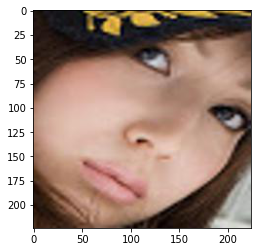

In [17]:
plt.imshow(X_test[0])
print("True name:", output_enc.inverse_transform([y_test_org[0]]))
print("Predict name: ",output_enc.inverse_transform([np.argmax(y_predict[0])]))

In [0]:
y_predict = model.predict(X_test)
predict_wrong = []
label_predict_wrong = []
for i in range(y_test.shape[0]):
  if np.argmax(y_predict[i]) != np.argmax(y_test[i]):
    predict_wrong.append(i)
    label_predict_wrong.append(np.argmax(y_test[i]))

In [48]:
from  collections import Counter
print(sorted(Counter(label_predict_wrong).items()))

[(0, 579)]


In [41]:
count_y_test = sorted(Counter(y_test_org).items())
count_y_predict_wrong_org = sorted(Counter(label_predict_wrong).items())
count_y_predict_wrong = []
count_miss = 0
len(count_y_predict_wrong_org)
for i in range(num_class):
  if i != count_y_predict_wrong_org[i - count_miss][0]:
    count_y_predict_wrong.append((i,0))
    count_miss += 1
  else: count_y_predict_wrong.append(count_y_predict_wrong_org[i - count_miss])
acuracy_per_class = []
for i in range (num_class):
  acuracy = (1 - count_y_predict_wrong[i][1] / count_y_test[i][1] ) *100
  print("Acuracy in " + str(output_enc.inverse_transform([i])) + " : " + str(round(acuracy)) + "%  | Wrong " + str(count_y_predict_wrong[i][1])+ "/" + str(count_y_test[i][1])  )
  acuracy_per_class.append((i,acuracy))


41

Name Idol predict: ['Mana Sakura']
Name Idol true: Mana Sakura


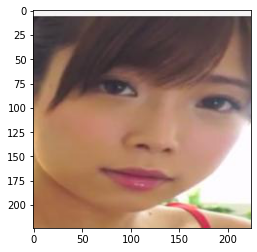

In [23]:
image = Image.open("test.jpg")
image =image.convert("RGB")
plt.imshow(image)
image = np.asarray(image)
image = image.reshape(1,224,224,3)
predict = model.predict(image)

name_idol_true = "Mana Sakura"
name_idol_predict = output_enc.inverse_transform([np.argmax(predict)])
print("Name Idol predict: " + str(name_idol_predict ))
print("Name Idol true: " + name_idol_true)